# Zillow 2023 Data

Mainly focused on costs, may need to produce some data for zoning if those comparisons are desired.

In [1]:
import json
import pandas as pd

# Replace with your JSON file path
filepath = "Zillow-ChapelHill-Spring2023-18k-Properties.json"

# Load the JSON file and convert to DataFrame
with open(filepath, "r", encoding="utf-8") as f:
    data = json.load(f)
df_23 = pd.DataFrame(data)
print(list(df_23.columns))

['zpid', 'address', 'bedrooms', 'bathrooms', 'price', 'yearBuilt', 'longitude', 'latitude', 'homeStatus', 'description', 'livingArea', 'currency', 'homeType', 'datePostedString', 'daysOnZillow', 'zestimate', 'rentZestimate', 'listedBy', 'timeOnZillow', 'pageViewCount', 'favoriteCount', 'isZillowOwned', 'priceHistory', 'isPremierBuilder', 'primaryPublicVideo', 'tourViewCount', 'postingContact', 'comingSoonOnMarketDate', 'timeZone', 'newConstructionType', 'lastSoldPrice', 'contingentListingType', 'restimateLowPercent', 'restimateHighPercent', 'brokerId', 'parcelId', 'isPreforeclosureAuction', 'listingProvider', 'marketingName', 'building', 'priceChange', 'lotSize', 'propertyTaxRate', 'whatILove', 'isFeatured', 'openHouseSchedule', 'brokerageName', 'taxHistory', 'abbreviatedAddress', 'isRecentStatusChange', 'isNonOwnerOccupied', 'buildingId', 'rentalApplicationsAcceptedType', 'tourEligibility', 'url', 'photos', 'chanceToSellFaster', 'dateSold', 'dateSoldString', 'taxAssessedValue', 'taxAs

In [2]:
import pandas as pd

# Load data
# df_23 = pd.read_csv('zillow_data_2023.csv')

# Set parameters
MAX_RENT = 50000
BEDROOM_RANGE = (1, 4)
BATHROOM_RANGE = (0.5, 3.0)
SNAPSHOT_DATE = pd.Timestamp('2023-03-31')

def process_rentals(df):
    # Calculate timeline metrics
    df['listing_date'] = SNAPSHOT_DATE - pd.to_timedelta(df['daysOnZillow'], unit='D')
    df['still_active'] = df['daysOnZillow'] == (SNAPSHOT_DATE - df['listing_date']).dt.days
    
    # Calculate removal date for non-active listings
    df['removal_date'] = pd.NaT
    df.loc[~df['still_active'], 'removal_date'] = df['listing_date'] + pd.to_timedelta(df['daysOnZillow'], unit='D')
    
    return df[
        (df['price'] <= MAX_RENT) &
        (df['bedrooms'].between(*BEDROOM_RANGE)) &
        (df['bathrooms'].between(*BATHROOM_RANGE)) &
        (df['listing_date'] >= '2020-01-01') &
        (df['listing_date'] <= SNAPSHOT_DATE)
    ]

# Process data
rentals_23 = process_rentals(df_23.copy())
rentals_23['bathrooms'] = rentals_23['bathrooms'].round(1)

# Create listing counts
listed_23 = (
    rentals_23.assign(month=rentals_23['listing_date'].dt.to_period('M'))
    .groupby(['month', 'bedrooms', 'bathrooms'])
    .size()
    .rename('listed')
)

# Create removal counts
removed_23 = (
    rentals_23[~rentals_23['still_active']]
    .assign(month=rentals_23['removal_date'].dt.to_period('M'))
    .query('month <= "2023-03"')
    .groupby(['month', 'bedrooms', 'bathrooms'])
    .size()
    .rename('removed')
)

# Combine results
result_23 = (
    pd.concat([listed_23, removed_23], axis=1)
    .fillna(0)
    .astype(int)
    .reset_index()
    .sort_values(['month', 'bedrooms', 'bathrooms'])
)

# Format output
result_23['bedrooms'] = result_23['bedrooms'].astype(int).astype(str) + 'BR'
result_23['bathrooms'] = result_23['bathrooms'].apply(lambda x: f"{x:.1f}BA")

print("Rental Market Activity Report (2020-2023)")
print(result_23[['month', 'bedrooms', 'bathrooms', 'listed', 'removed']]
      .to_string(index=False))

Rental Market Activity Report (2020-2023)
  month bedrooms bathrooms  listed  removed
2020-01      2BR     1.5BA       1        0
2020-01      2BR     2.0BA       1        0
2020-04      3BR     1.0BA       1        0
2020-10      3BR     2.0BA       1        0
2020-10      4BR     2.0BA       1        0
2021-04      3BR     2.0BA       1        0
2022-06      2BR     1.0BA       1        0
2022-06      3BR     2.0BA       1        0
2022-06      3BR     3.0BA       1        0
2022-09      3BR     2.0BA       1        0
2022-12      3BR     2.0BA       1        0
2022-12      3BR     2.5BA       1        0
2023-01      3BR     2.0BA       2        0
2023-01      3BR     2.5BA       1        0
2023-02      2BR     1.5BA       1        0
2023-02      2BR     2.0BA       2        0
2023-02      2BR     2.5BA       2        0
2023-02      4BR     2.0BA       1        0
2023-02      4BR     3.0BA       1        0
2023-03      1BR     1.0BA       6        0
2023-03      2BR     1.0BA       1

### Database File Creation

This is an example of converting the .json to a .db with sqlite. Potentially useful for simple visualized tables in combination with VSCode extensions.

In [ ]:
# import json
# import pandas as pd
# import sqlite3

# # Replace with your JSON file path
# filepath = "Zillow-ChapelHill-Spring2023-18k-Properties.json"

# # Load the JSON file and convert to DataFrame
# with open(filepath, "r", encoding="utf-8") as f:
#     data = json.load(f)
# df = pd.DataFrame(data)

# # Convert non-stringable objects (like dicts/lists) to JSON strings
# for col in df.columns:
#     df[col] = df[col].apply(lambda x: json.dumps(x) if isinstance(x, (dict, list)) else x)

# # Save to SQLite database
# sqlite_filename = "zillow_chapelhill.db"
# with sqlite3.connect(sqlite_filename) as conn:
#     df.to_sql("properties", conn, if_exists="replace", index=False)

# print(f"Database file '{sqlite_filename}' created with table 'properties'.")


# Zillow 2025 Data

More robust in both categories and datapoints than 2023 information.

In [3]:
import json
import pandas as pd

# Replace with your JSON file path
files = [
    "Zillow_Data_2025/Zillow-March2025-dataset_part0.json",
    "Zillow_Data_2025/Zillow-March2025-dataset_part1.json",
    "Zillow_Data_2025/Zillow-March2025-dataset_part2.json",
    "Zillow_Data_2025/Zillow-March2025-dataset_part3.json"
    ]

# Load the JSON file and convert to DataFrame
full_data = []
for file in files:
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
        full_data.extend(data)
df_25 = pd.DataFrame(full_data)
print(list(df_25.columns))

['zpid', 'listingSource', 'listingAccount', 'ownerAccount', 'lfaViewPropertyPageUrl', 'listingOwnerConfigIDs', 'postingPresentationTypes', 'maloneId', 'city', 'state', 'homeStatus', 'address', 'isListingClaimedByCurrentSignedInUser', 'isCurrentSignedInAgentResponsible', 'bedrooms', 'bathrooms', 'price', 'yearBuilt', 'streetAddress', 'zipcode', 'isCurrentSignedInUserVerifiedOwner', 'propertyUpdatePageLink', 'moveHomeMapLocationLink', 'propertyEventLogLink', 'editPropertyHistorylink', 'isVerifiedClaimedByCurrentSignedInUser', 'listingDataSource', 'responsivePhotos', 'longitude', 'latitude', 'hasBadGeocode', 'isCamo', 'listing_sub_type', 'streetViewMetadataUrlMediaWallLatLong', 'streetViewMetadataUrlMediaWallAddress', 'streetViewServiceUrl', 'streetView', 'staticMap', 'livingArea', 'homeType', 'lotSize', 'lotAreaValue', 'lotAreaUnits', 'livingAreaValue', 'livingAreaUnitsShort', 'resoFacts', 'isUndisclosedAddress', 'formattedChip', 'zestimate', 'rentZestimate', 'currency', 'hideZestimate',

In [ ]:
pd.set_option('display.max_columns', None)
df_25.head()

In [4]:
# List of relevant columns to keep
columns_to_keep = [
    # Core property info
    'price', 'bedrooms', 'bathrooms', 'yearBuilt', 'livingArea',
    'lotSize', 'homeType', 'propertyTypeDimension',
    'zipcode', 'city', 'state', 'latitude', 'longitude',
    
    # Financial info
    'zestimate', 'zestimateLowPercent', 'zestimateHighPercent',
    'rentZestimate', 'restimateLowPercent', 'restimateHighPercent',
    'taxAssessedValue', 'taxAssessedYear', 'propertyTaxRate',
    'monthlyHoaFee', 'hoaFee', 'lastSoldPrice',

    # Market activity / trends
    'dateSold', 'dateSoldString', 'daysOnZillow', 'priceHistory', 'taxHistory',
    'forecast', 'zestimateMinus30', 'restimateMinus30',

    # Neighborhood and zoning context
    'county', 'countyFIPS', 'neighborhoodRegion', 'building',
    'isZillowOwned', 'isNonOwnerOccupied',

    # Schools and surrounding info
    'schools', 'nearbyHomes', 'nearbyCities', 'nearbyNeighborhoods', 'nearbyZipcodes',
]

# Filter the DataFrame
df_25_filtered = df_25[columns_to_keep].copy()

# Optional: quick inspection
df_25_filtered.info()
df_25_filtered.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32033 entries, 0 to 32032
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  32033 non-null  int64  
 1   bedrooms               28143 non-null  float64
 2   bathrooms              28661 non-null  float64
 3   yearBuilt              27419 non-null  float64
 4   livingArea             28601 non-null  float64
 5   lotSize                27157 non-null  float64
 6   homeType               32033 non-null  object 
 7   propertyTypeDimension  32033 non-null  object 
 8   zipcode                31978 non-null  object 
 9   city                   31979 non-null  object 
 10  state                  31979 non-null  object 
 11  latitude               31967 non-null  float64
 12  longitude              31967 non-null  float64
 13  zestimate              27525 non-null  float64
 14  zestimateLowPercent    27525 non-null  object 
 15  ze

,price,bedrooms,bathrooms,yearBuilt,livingArea,lotSize,homeType,propertyTypeDimension,zipcode,city,...,countyFIPS,neighborhoodRegion,building,isZillowOwned,isNonOwnerOccupied,schools,nearbyHomes,nearbyCities,nearbyNeighborhoods,nearbyZipcodes
0,764100,5.0,2.5,1991.0,3013.0,15245.0,SINGLE_FAMILY,Single Family,27510,Carrboro,...,37135,None,None,False,False,"[{'distance': 0.4, 'name': 'Frank P Graham Ele...","[{'zpid': 50032767, 'miniCardPhotos': [{'url':...","[{'regionUrl': {'path': '/carrboro-nc/'}, 'nam...",[],[{'regionUrl': {'path': '/carrboro-nc-27510/'}...
1,829100,8.0,6.0,1927.0,3217.0,11324.0,APARTMENT,Apartment,27516,Chapel Hill,...,37135,{'name': 'Cameron-Mccauley'},None,False,False,"[{'distance': 0.5, 'name': 'Unc Hospital Schoo...","[{'zpid': 60074726, 'miniCardPhotos': [{'url':...","[{'regionUrl': {'path': '/apex-nc/'}, 'name': ...",[{'regionUrl': {'path': '/abbotts-colony-chape...,[{'regionUrl': {'path': '/chapel-hill-nc-27514...
2,965600,4.0,3.5,1997.0,3009.0,535788.0,SINGLE_FAMILY,Single Family,27516,Chapel Hill,...,37135,None,None,False,False,"[{'distance': 6.4, 'name': 'Grady Brown Elemen...","[{'zpid': 2131823074, 'miniCardPhotos': [{'url...","[{'regionUrl': {'path': '/apex-nc/'}, 'name': ...",[{'regionUrl': {'path': '/abbotts-colony-chape...,[{'regionUrl': {'path': '/chapel-hill-nc-27514...
3,453400,4.0,2.0,1992.0,1658.0,125452.0,SINGLE_FAMILY,Single Family,27516,Chapel Hill,...,37135,None,None,False,False,"[{'distance': 11.3, 'name': 'Grady Brown Eleme...","[{'zpid': 88946586, 'miniCardPhotos': [{'url':...","[{'regionUrl': {'path': '/apex-nc/'}, 'name': ...",[{'regionUrl': {'path': '/abbotts-colony-chape...,[{'regionUrl': {'path': '/chapel-hill-nc-27514...
4,701600,2.0,1.0,1942.0,1120.0,23958.0,APARTMENT,Apartment,27516,Chapel Hill,...,37135,{'name': 'Cameron-Mccauley'},None,False,False,"[{'distance': 0.5, 'name': 'Unc Hospital Schoo...","[{'zpid': 50037264, 'miniCardPhotos': [{'url':...","[{'regionUrl': {'path': '/apex-nc/'}, 'name': ...",[{'regionUrl': {'path': '/abbotts-colony-chape...,[{'regionUrl': {'path': '/chapel-hill-nc-27514...


In [5]:
import pandas as pd

# Load data
# df_25 = pd.read_csv('zillow_data.csv')

# Set parameters
MAX_RENT = 50000
BEDROOM_RANGE = (1, 4)
BATHROOM_RANGE = (0.5, 3.0)
SNAPSHOT_DATE = pd.Timestamp('2025-03-31')

def process_rentals(df):
    # Calculate timeline metrics
    df['listing_date'] = SNAPSHOT_DATE - pd.to_timedelta(df['daysOnZillow'], unit='D')
    df['still_active'] = df['daysOnZillow'] == (SNAPSHOT_DATE - df['listing_date']).dt.days
    
    # Calculate removal date only for non-active listings
    df['removal_date'] = pd.NaT
    df.loc[~df['still_active'], 'removal_date'] = df['listing_date'] + pd.to_timedelta(df['daysOnZillow'], unit='D')
    
    return df[
        (df['price'] <= MAX_RENT) &
        (df['bedrooms'].between(*BEDROOM_RANGE)) &
        (df['bathrooms'].between(*BATHROOM_RANGE)) &
        (df['listing_date'] >= '2020-01-01')
    ]

# Process data
rentals_25 = process_rentals(df_25.copy())
rentals_25['bathrooms'] = rentals_25['bathrooms'].round(1)

# Create listing counts
listed_25 = (
    rentals_25.assign(month=rentals_25['listing_date'].dt.to_period('M'))
    .groupby(['month', 'bedrooms', 'bathrooms'])
    .size()
    .rename('listed')
)

# Create removal counts
removed_25 = (
    rentals_25[~rentals_25['still_active']]
    .assign(month=rentals_25['removal_date'].dt.to_period('M'))
    .query('month <= "2025-03"')
    .groupby(['month', 'bedrooms', 'bathrooms'])
    .size()
    .rename('removed')
)

# Combine results
result_25 = (
    pd.concat([listed_25, removed_25], axis=1)
    .fillna(0)
    .astype(int)
    .reset_index()
    .sort_values(['month', 'bedrooms', 'bathrooms'])
)

# Format output
result_25['bedrooms'] = result_25['bedrooms'].astype(int).astype(str) + 'BR'
result_25['bathrooms'] = result_25['bathrooms'].apply(lambda x: f"{x:.1f}BA")

print("Accurate Rental Market Activity (2020-2025):")
print(result_25[['month', 'bedrooms', 'bathrooms', 'listed', 'removed']]
      .to_string(index=False))

Accurate Rental Market Activity (2020-2025):
  month bedrooms bathrooms  listed  removed
2020-05      2BR     3.0BA       1        0
2020-09      2BR     2.0BA       1        0
2021-01      2BR     2.0BA       1        0
2021-03      2BR     2.0BA       1        0
2021-03      2BR     2.5BA       1        0
2021-08      2BR     2.0BA       1        0
2021-10      2BR     2.0BA       1        0
2022-02      2BR     2.0BA       1        0
2022-06      3BR     2.0BA       1        0
2022-07      4BR     3.0BA       1        0
2022-08      2BR     2.0BA       1        0
2022-08      3BR     2.0BA       1        0
2022-12      3BR     2.0BA       1        0
2023-02      4BR     2.0BA       1        0
2023-03      2BR     1.0BA       1        0
2023-03      3BR     2.0BA       1        0
2023-10      3BR     3.0BA       1        0
2023-11      2BR     2.0BA       1        0
2023-11      3BR     2.0BA       1        0
2024-01      1BR     1.0BA       3        0
2024-02      3BR     2.0BA     

In [ ]:
# # Calculate market duration stats
# dom_stats = (
#     rentals.query('listing_date >= "2023-01-01"')
#     .assign(
#         bedrooms=lambda x: x['bedrooms'].astype(int),
#         bathrooms=lambda x: x['bathrooms'].round(1)
#     )
#     .groupby(['bedrooms', 'bathrooms'])
#     .agg(
#         property_count=('daysOnZillow', 'size'),
#         avg_days_on_market=('daysOnZillow', 'mean'),
#         median_days_on_market=('daysOnZillow', 'median')
#     )
#     .reset_index()
#     .sort_values(['bedrooms', 'bathrooms'])
#     .round(1)
# )

# # Format output
# dom_stats['bedrooms'] = dom_stats['bedrooms'].astype(str) + 'BR'
# dom_stats['bathrooms'] = dom_stats['bathrooms'].astype(str) + 'BA'

# print("Average Days on Market (2023-2025 Listings):")
# print(dom_stats.to_string(index=False, formatters={
#     'avg_days_on_market': '{:.0f}'.format,
#     'median_days_on_market': '{:.0f}'.format
# }))

# Joint Comparison

In [7]:
# Trim and prepare datasets with proper column alignment
rentals_23_trim = rentals_23[[
    'latitude', 'longitude', 'address',  # df_23 uses 'address' instead of 'streetAddress'
    'listing_date', 'removal_date', 
    'bedrooms', 'bathrooms', 'daysOnZillow'
]].rename(columns={'address': 'streetAddress'}).copy()

rentals_25_trim = rentals_25[[
    'latitude', 'longitude', 'streetAddress',
    'listing_date', 'removal_date',
    'bedrooms', 'bathrooms', 'daysOnZillow'
]].copy()

# Combine datasets with suffixes
combined = pd.concat(
    [
        rentals_23_trim.add_suffix('_23'),
        rentals_25_trim.add_suffix('_25')
    ],
    axis=0,
    ignore_index=True
)

# Create duplicate keys with proper address handling
combined['coord_key'] = (
    combined['latitude_23'].fillna(combined['latitude_25'])
    .round(5).astype(str) + '|' +
    combined['longitude_23'].fillna(combined['longitude_25'])
    .round(5).astype(str)
)

combined['address_key'] = (
    combined['streetAddress_23']
    .fillna(combined['streetAddress_25'])  # Now works for both datasets
    .str.lower().str.strip()
    .str.replace(r'[^a-z0-9\s]', '', regex=True)  # Normalize addresses
    .str.replace(r'\s+', ' ', regex=True)
)

# Remove duplicates (keep earliest listing)
combined = combined.sort_values(
    by=['listing_date_23', 'listing_date_25'],
    ascending=[True, True]
).drop_duplicates(
    subset=['coord_key', 'address_key'],
    keep='first'
)

# Create unified columns
combined['listing_date'] = (
    combined['listing_date_23']
    .fillna(combined['listing_date_25'])
)
combined['removal_date'] = (
    combined['removal_date_23']
    .fillna(combined['removal_date_25'])
)
combined['bedrooms'] = (
    combined['bedrooms_23']
    .fillna(combined['bedrooms_25'])
    .astype(int)
)
combined['bathrooms'] = (
    combined['bathrooms_23']
    .fillna(combined['bathrooms_25'])
    .round(1)
)

# Generate activity report
combined_listed = (
    combined.assign(month=combined['listing_date'].dt.to_period('M'))
    .groupby(['month', 'bedrooms', 'bathrooms'])
    .size()
    .rename('listed')
)

combined_removed = (
    combined[~combined['removal_date'].isna()]
    .assign(month=combined['removal_date'].dt.to_period('M'))
    .groupby(['month', 'bedrooms', 'bathrooms'])
    .size()
    .rename('removed')
)

# Combine results
combined_result = (
    pd.concat([combined_listed, combined_removed], axis=1)
    .fillna(0)
    .astype(int)
    .reset_index()
    .sort_values(['month', 'bedrooms', 'bathrooms'])
)

# Format output
combined_result['bedrooms'] = combined_result['bedrooms'].astype(str) + 'BR'
combined_result['bathrooms'] = combined_result['bathrooms'].apply(lambda x: f"{x:.1f}BA")

print("Optimized Combined Report (2020-2025)")
print(combined_result[['month', 'bedrooms', 'bathrooms', 'listed', 'removed']]
      .to_string(index=False))

Optimized Combined Report (2020-2025)
  month bedrooms bathrooms  listed  removed
2020-01      2BR     1.5BA       1        0
2020-01      2BR     2.0BA       1        0
2020-04      3BR     1.0BA       1        0
2020-05      2BR     3.0BA       1        0
2020-09      2BR     2.0BA       1        0
2020-10      3BR     2.0BA       1        0
2020-10      4BR     2.0BA       1        0
2021-01      2BR     2.0BA       1        0
2021-03      2BR     2.0BA       1        0
2021-03      2BR     2.5BA       1        0
2021-04      3BR     2.0BA       1        0
2021-08      2BR     2.0BA       1        0
2021-10      2BR     2.0BA       1        0
2022-02      2BR     2.0BA       1        0
2022-06      2BR     1.0BA       1        0
2022-06      3BR     2.0BA       2        0
2022-06      3BR     3.0BA       1        0
2022-07      4BR     3.0BA       1        0
2022-08      2BR     2.0BA       1        0
2022-08      3BR     2.0BA       1        0
2022-09      3BR     2.0BA       1    

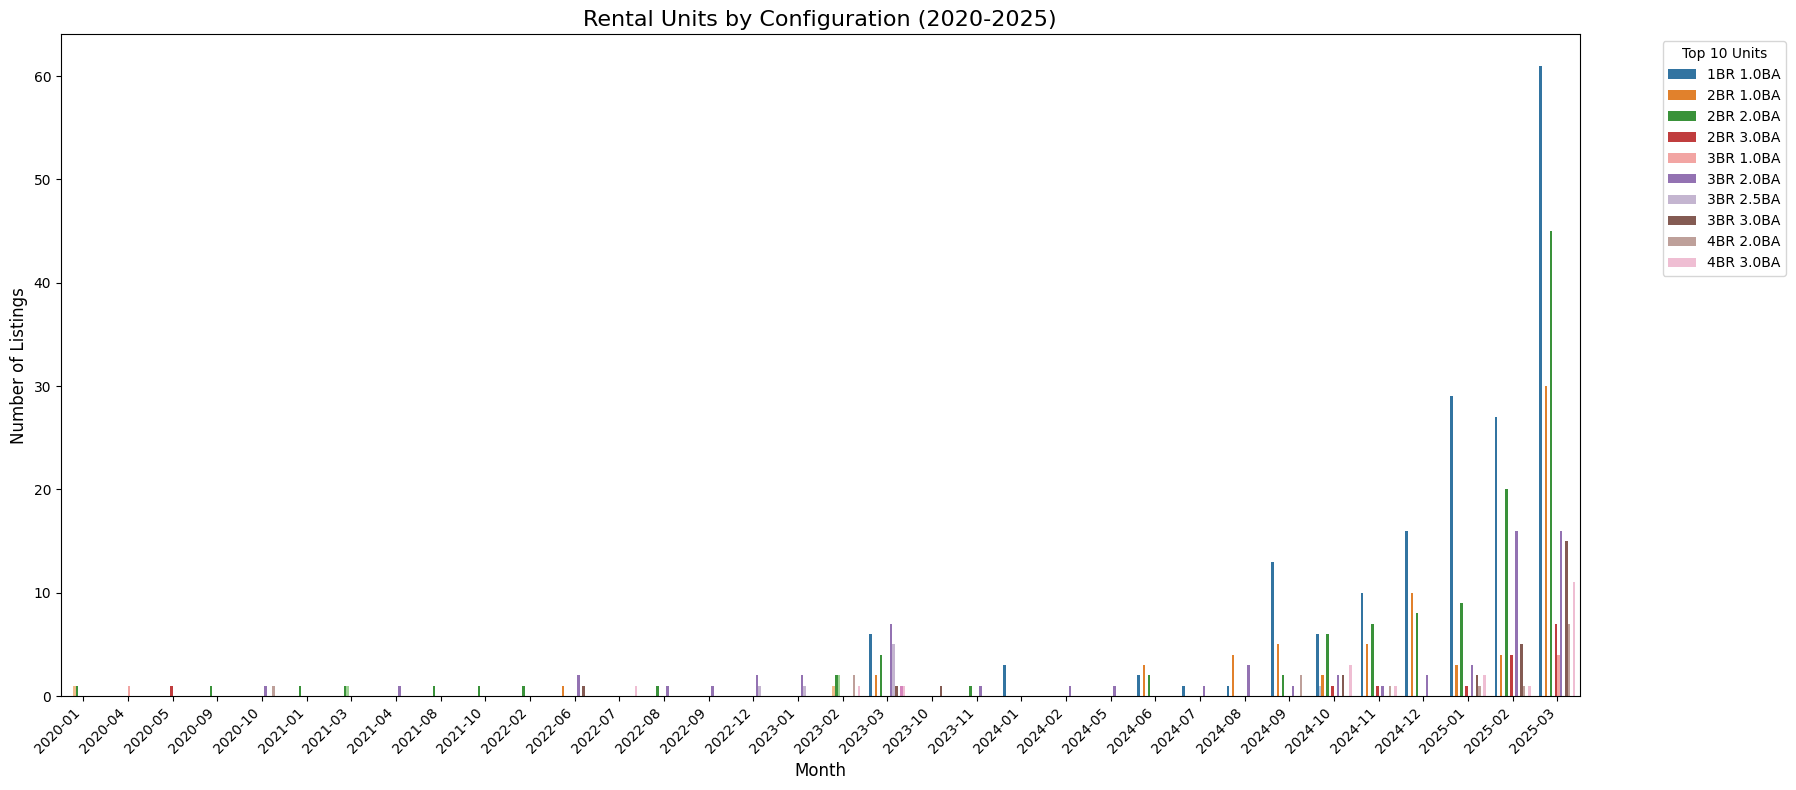

In [10]:
# Create unit type identifier
combined_result['unit_type'] = combined_result['bedrooms'] + ' ' + combined_result['bathrooms']

# Pivot data for stacked bar chart
pivot_data = combined_result.pivot_table(
    index='month',
    columns='unit_type',
    values='listed',
    aggfunc='sum',
    fill_value=0
).reset_index()

# Get top 10 most common unit types for coloring
top_units = combined_result.groupby('unit_type')['listed'].sum().nlargest(10).index

# Create plot
plt.figure(figsize=(18, 8))
ax = sns.barplot(
    data=pivot_data.melt(id_vars='month'),
    x='month',
    y='value',
    hue='unit_type',
    palette='tab20',
    estimator=sum,
    dodge=True
)

plt.title('Rental Units by Configuration (2020-2025)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Unit Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Highlight top units in legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    [h for h, l in zip(handles, labels) if l in top_units],
    [l for l in labels if l in top_units],
    title='Top 10 Units',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()